In [1]:
### Setup
%matplotlib inline
# %load_ext pretty_jupyter

# should enable plotting without explicit call .show()

# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from collections import Counter

# classes for special types
from pandas.api.types import CategoricalDtype

# Apply the default theme
sns.set_theme()

## Introduction

In this report, we're going to predict how many goals will NHL players score next season. The prediction will be based on various player's data, such as average ice-time, age, shooting percentage, etc. from past seasons.

## Dataset overview

The provided dataset consists of 2 csv files:

### `nhl-teams.csv`:

This file contains names of NHL teams together with their short name.
There are 35 rows (1 row = 1 team) and only 2 columns. The structure is as follows:


In [2]:
# Reading and inspecting data
df = pd.read_csv("data/nhl-teams.csv")
df.head(5)

,team,team_full
0,ANA,Anaheim Ducks
1,ARI,Arizona Coyottes
2,ATL,Atlanta Thrashers
3,BOS,Boston Bruins
4,BUF,Buffalo Sabres


### `nhl-player-data.csv`

This file contains various data about NHL players (goals, points per season, average time on ice, age, etc.) for seasons 2004-2018.
Each row contains data for the given player per season, i.e. if the player has played multiple seasons in NHL, there will be multiple rows containing his data (1 row per each season).

Size of the dataset is about 1.34 MB  
There are 12328 rows and 32 columns

Structure is as follows:


In [3]:
df = pd.read_csv("data/nhl-player-data.csv")
df.head(5)

,Rk,Player,Nick,Age,Pos,Tm,GP,G,A,PTS,...,TOI,ATOI,BLK,HIT,FOW,FOL,FO_percent,HART,Votes,Season
0,1,Connor McDavid,mcdavco01,20,C,EDM,82,30,70,100,...,1733,21.133333,29.0,34,348.0,458.0,43.2,1,1604,2017
1,2,Sidney Crosby,crosbsi01,29,C,PIT,75,44,45,89,...,1491,19.883333,27.0,80,842.0,906.0,48.2,0,1104,2017
2,3,Patrick Kane,kanepa01,28,RW,CHI,82,34,55,89,...,1754,21.400000,15.0,28,7.0,44.0,13.7,0,206,2017
3,4,Nicklas Backstrom,backsni02,29,C,WSH,82,23,63,86,...,1497,18.266667,33.0,45,685.0,648.0,51.4,0,60,2017
4,5,Nikita Kucherov,kucheni01,23,RW,TBL,74,40,45,85,...,1438,19.433333,20.0,30,0.0,0.0,0.0,0,119,2017


Types of the columns are displayed below:


In [4]:
df.dtypes

Rk              int64
Player         object
Nick           object
Age             int64
Pos            object
Tm             object
GP              int64
G               int64
A               int64
PTS             int64
plusminus       int64
PIM             int64
PS            float64
EV              int64
PP              int64
SH              int64
GW              int64
EV.1            int64
PP.1            int64
SH.1            int64
S               int64
S_percent     float64
TOI             int64
ATOI          float64
BLK           float64
HIT             int64
FOW           float64
FOL           float64
FO_percent    float64
HART            int64
Votes           int64
Season          int64
dtype: object

As we mentioned before, we're mostly interested in predicting goals per season.
The distribution of goals per season in our dataset looks like this:


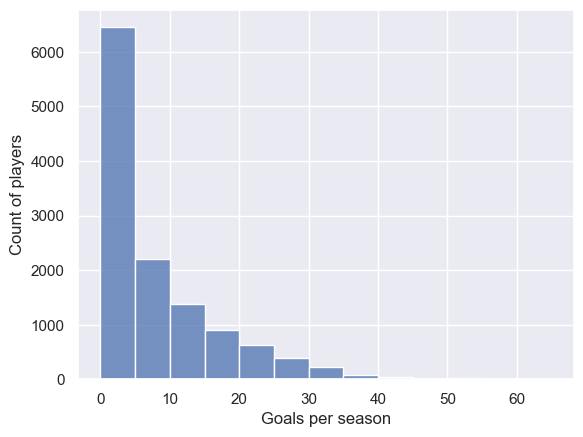

In [5]:
g = sns.histplot(data=df, x="G", binwidth=5)
plt.xlabel("Goals per season")
plt.ylabel("Count of players")

plt.show()

Here are the descriptive statistics:


In [6]:
df["G"].describe()

count    12328.000000
mean         7.484263
std          8.846936
min          0.000000
25%          1.000000
50%          4.000000
75%         11.000000
max         65.000000
Name: G, dtype: float64

We can see, that the average player scores about 7.5 goals per season, the maximum is 65 goals per season, and over 20% of players didn't score any goal in a season.


The graph below shows distribution of players by season.


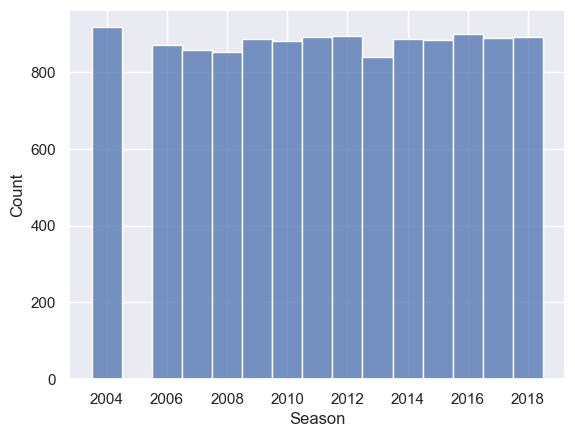

In [7]:
g = sns.histplot(data=df, x="Season", discrete=True)

We can see that the data are evenly distributed between seasons, however data for 2005 are missing because the season was cancelled.


#### Missing values

In total there are 438 missing cells in the dataset, which is about 0.1% of all cells.
These are mostly concentrated in two columns:

- FO_percent (faceoff win percentage)
- S_percent (shooting percentage)

In my opinion, this is most likely caused by the fact that the given players didn't take any faceoffs during the season (e.g. defensemen typically don't take faceoffs), or respectively didn't shoot at the goal (maybe the given player played just 1 game in whole season). Both cases will result in division by zero.

There is also 1 missing value in each of the following columns: BLK, FOW and FOL.

Missing values aren't denoted by any special strings (such as "None" or "Null"), there are just 2 consecutive commas in the given row.

There is one row with player whose age is 0, which is definitely an error in the dataset.


## Exploratory analysis

We're going to explore relations in the dataset.

Note: Players who scored 0 goals in a given season are excluded from all graphs.

### Goals & player's age

Firstly, we're going to explore whether the player's age correlates with the goals scored in any way.


In [8]:
df = df.loc[df["G"] > 0]

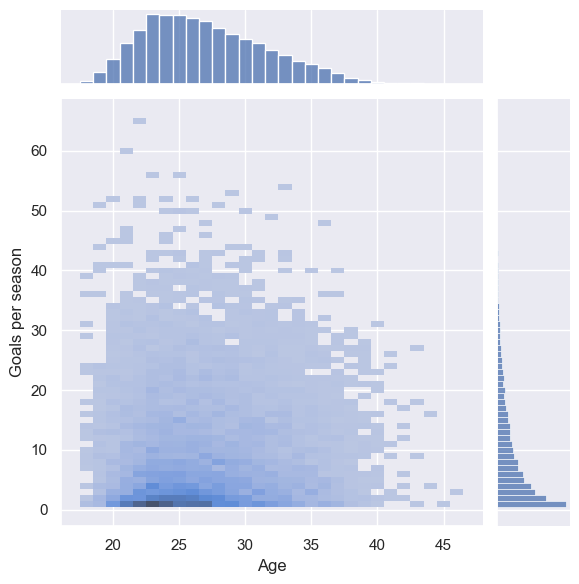

In [9]:
g = sns.JointGrid(data=df, x="Age",y="G")
g1 = g.plot(sns.histplot, sns.histplot, discrete=True)
g2 = g1.set_axis_labels("Age", "Goals per season")

From the graph above, we see that suprisingly, there is no visible correlation between these 2 variables. The best results belong to players aged 20-25 results, however these players are also the most represented group in the dataset.


### Goals & shooting percentage

In this part, we'll explore whether the goals scored depend on player's shooting percentage.  
Here is a graph showing relation of these 2 variables.


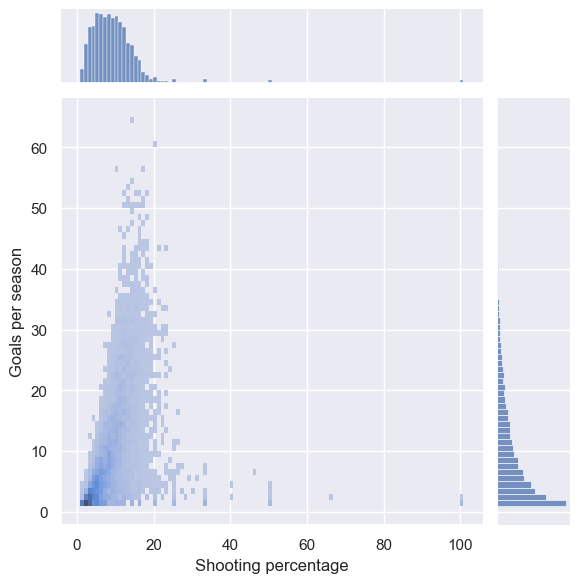

In [10]:
df_scored = df.loc[df["S_percent"] > 0]
g = sns.JointGrid(data=df_scored, x="S_percent",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Shooting percentage", "Goals per season")

From the graph, it seems that the number of goals directly depends on shooting percentage.
So, we can formulate the following hypothesis: The better shoting percentage, the more goals scored.

Of course, this doesn't apply to all data (e.g. there are several players with shooting percentage >= 50% and none of them scored more than 5 goals), however on average it seems to be true.


### Goals & average time on ice

In this section, we're going to explore relation between goals scored and average time on ice.  
Here is the graph showing relation between these 2 variables:


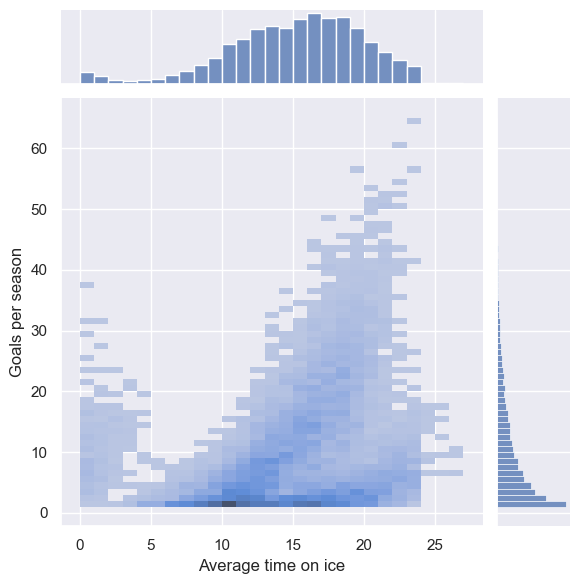

In [11]:
g = sns.JointGrid(data=df, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can observe that the graph contains 2 clusters (one goes from `average time on ice = 10` up right and second one goes from the same position to the right).

In my opinion, the first cluster contains forwards and the second one contains defencemen, who often spend a lot of time on ice, however don't score as much as forwards.
There is also some strange data at the left showing players who spend on average < 5 minutes on ice, but score many goals (over 10 or even 20 goals per season).

The following graph shows the same relation but this time only for forwards:


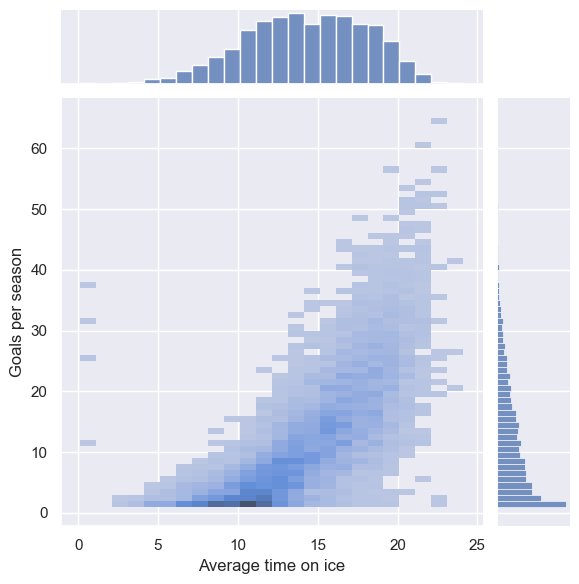

In [12]:
df_forwards = df.loc[df["Pos"].isin(["C","LW","RW"])]

g = sns.JointGrid(data=df_forwards, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can see that the first cluster indeed mostly consists of forwards.  
The graph also suggests that for **forwards**, we can formulate the following hypothesis: Number of scored goals directly depends on average time on ice (the higher ice time, the more goals).

The same graph but for defencemen, looks like this:


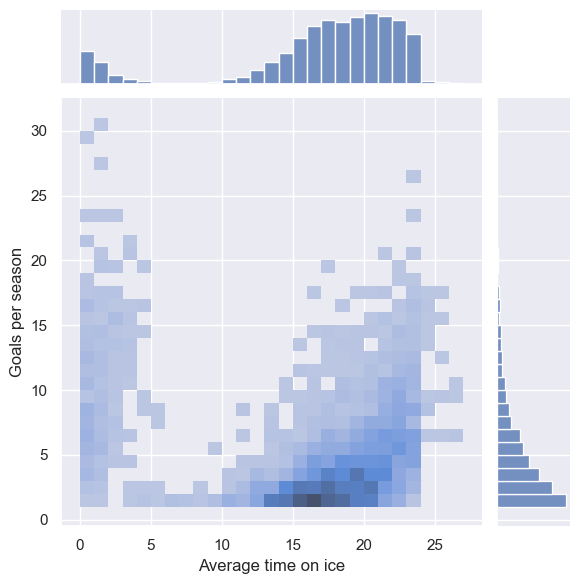

In [13]:
df_forwards = df.loc[df["Pos"] == "D"]

g = sns.JointGrid(data=df_forwards, x="ATOI",y="G")
g1 = g.plot(sns.histplot, sns.histplot, binwidth=1)
g2 = g1.set_axis_labels("Average time on ice", "Goals per season")

We can observe that most of the strange data (players who spend on average < 5 minutes on ice, but score many goals) from the graph above belong to defencemen.

After looking at these suspicious data, we see that the average time on ice is miscalculated.
If we divide total time on ice (TOI) by games played (GP), we should get average time on ice (ATOI). However, for these data ATOI is way smaller (mostly in the range 0-5) than the real value (see `ATOI_real` column in the table below). Therefore, it's an error in the data (for further data processing, we may recalculate ATOI values).


In [14]:
df_sus = df.loc[(df["G"] > 10) & (df["ATOI"] <= 2) & (df["Pos"] == "D"),["Player","Season","Pos","GP","G","TOI","ATOI"]]
df_sus["ATOI_real"] = df_sus["TOI"] / df_sus["GP"]
df_sus.head(5)

,Player,Season,Pos,GP,G,TOI,ATOI,ATOI_real
8,Brent Burns,2017,D,82,29,2039,0.866667,24.865854
15,Victor Hedman,2017,D,79,16,1936,0.500000,24.506329
107,Roman Josi,2017,D,72,12,1805,1.066667,25.069444
110,Alex Pietrangelo,2017,D,80,14,2023,1.283333,25.287500
148,Shea Weber,2017,D,78,17,1955,1.066667,25.064103


After exluding these error data, we see that for defencemen, there is a similar hypothesis: Higher average time on ice typically means more scored goals.


## Data preparation
### Cleaning

As mentioned before, there are some wrong data in the dataset.
I executed the following steps in order to clean it:

- removed the player, whose age is 0
- removed the players that had missing values in columns BLK, FOW and FOL (3 rows in total)
- replaced missing values in `S_percent` column by zeros. I checked that all of the players, whose `S_percent` value is missing, scored zero goals, therefore setting it to zero is correct.
- similarly, I replaced missing `FO_percent` values by zeros (again, I checked that these players didn't win any faceoff).
- recalculated all `ATOI` values (as mentioned in the previous section, some of the values are wrong).


In [15]:
df = pd.read_csv("data/nhl-player-data.csv")
df = df.loc[df["BLK"].notna() & (df["FOW"].notna()) & (df["FOL"].notna()) & (df["Age"] > 0)]
df["ATOI"] = df["TOI"] / df["GP"]

df["S_percent"] = df["S_percent"].fillna(0)
df["FO_percent"] = df["FO_percent"].fillna(0)

### Transformation
For predicting number of scored goals in the next season, I used only players, who played at least 3 consecutive seasons in NHL. 
If a player has player more seasons in NHL, he will be present in multiple rows of training data (one row for each triple of consecutive seasons).

I used the limit of 3 seasons, because more than half of the players satisfies the condition (and therefore will be included in training data) and it's showing some progress of the player.
If the limit was lower, there will probably be too little information (only 1 season in training data).

I extracted the following features from data:
- goals scored
- shooting percentage
- average time on ice
for first and second season. (The number of scored goals in the last (i.e. 3rd) season will be used as a target.)

In addition to shooting percentage and ATOI mentioned in hypotheses, I also added goals scored in the seasons as features, because in my opinion it has a big impact on the prediciton for next season.
Furthermore, I also added one-hot encoded position of the player into features, because it affects the prediction quite a lot (as shown in the relation between ATOI and goals).

The transformed data look like this:

In [16]:
TRAIN_SEASONS = 2

def most_common(lst):
    return max(set(lst), key=lst.count)

def get_four_consecutives(numbers):
    numbers.sort()
    if len(numbers) < TRAIN_SEASONS + 1:
        return None
        
    consecutives, has_results = [], False
    
    for i in range(len(numbers) - TRAIN_SEASONS):
        y1, y2, y3 = numbers[i:i + TRAIN_SEASONS + 1]
        if y1 + 1 == y2 and y1 + 2 == y3:
            consecutives += [(y1, y2, y3)]
            has_results = True

    return consecutives if has_results else None


def normalize(row):
    seasons, last_season = row["Con_seasons"][:-1], row["Con_seasons"][-1]
    indexes = [row["Season"].index(s) for s in seasons]
    target_index = row["Season"].index(last_season)

    row["target"] = row["G"][target_index]
    row["Pos"] = most_common(row["Pos"])

    for col_index, i in enumerate(indexes):
        row[f"G_{col_index}"] = row["G"][i]
        row[f"S_percent_{col_index}"] = row["S_percent"][i]
        row[f"ATOI_{col_index}"] = row["ATOI"][i]
    
    return row

# Group the data by player
players_agg = df.groupby(["Player"]).aggregate(lambda x: list(x))
players_agg["Con_seasons"] = players_agg["Season"].apply(get_four_consecutives)
players_agg = players_agg.loc[players_agg["Con_seasons"].notna()]
players_agg = players_agg.explode("Con_seasons")

# create features for each season
players_agg = players_agg.apply(normalize, axis=1)

# select the right columns
columns = ["Pos"]
for i in range(TRAIN_SEASONS):
    columns += [f"G_{i}", f"S_percent_{i}", f"ATOI_{i}"]

targets = players_agg["target"]
players_agg = players_agg[columns]

# Get one hot encoding of Position
one_hot = pd.get_dummies(players_agg['Pos'], prefix='Pos')
players_agg = players_agg.drop('Pos', axis = 1)
players_agg = pd.concat([players_agg, one_hot], axis=1)

players_agg.sample(n=10)

,G_0,S_percent_0,ATOI_0,G_1,S_percent_1,ATOI_1,Pos_C,Pos_D,Pos_LW,Pos_RW
Player,,,,,,,,,,
Joe Colborne,10,12.5,14.262500,0,0.0,9.200000,1,0,0,0
Chris Kelly,7,6.3,15.137500,9,13.0,14.701754,1,0,0,0
Keith Yandle,5,2.8,22.036585,5,3.1,19.963415,0,1,0,0
Dwight King,15,13.5,15.038961,4,6.7,12.765957,0,0,1,0
Cody Almond,1,14.3,10.200000,0,0.0,7.000000,1,0,0,0
Daniel Alfredsson,29,12.1,21.571429,43,17.3,21.688312,0,0,0,1
Mark Letestu,14,10.9,14.250000,1,11.1,9.600000,1,0,0,0
Marco Sturm,27,11.8,18.000000,27,12.1,18.592105,0,0,1,0
Dave Bolland,1,3.8,14.080000,6,7.9,16.358491,1,0,0,0


## Modeling
The model is based on [Linear regression](https://en.wikipedia.org/wiki/Linear_regression) with cross-validation.

I implemented the cross-validation using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) model from `sklearn` library with the following parameters: 
- number of folds: 5 (default value)
- [Regression parameters](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for GridSearch: `{'positive': [True, False]}` . Thus, GridSearch will search over specified parameter values for the best estimator, and use it.

I used 90% of the data for training and the remaining 10% for testing.

Parameters of the model (weights of the features) are displayed below:

In [100]:
X_train, X_test, y_train, y_test = train_test_split(players_agg, targets, train_size=0.9)

parameters = {'positive': [True, False]}

model = GridSearchCV(LinearRegression(), parameters, scoring="neg_root_mean_squared_error").fit(X_train, y_train)

In [101]:
feature_weights = pd.DataFrame({'feature' : []})
feature_weights["feature"] = players_agg.columns
feature_weights["weight"] = model.best_estimator_.coef_ 

feature_weights

,feature,weight
0,G_0,0.233796
1,S_percent_0,-0.032194
2,ATOI_0,0.066804
3,G_1,0.337551
4,S_percent_1,-0.078534
5,ATOI_1,0.521301
6,Pos_C,1.076396
7,Pos_D,-5.205038
8,Pos_LW,2.101399
9,Pos_RW,2.027243


We see that our model assigned the highest weights to `Pos_LW` and `Pos_RW` features, while `Pos_D` has the smallest (negative) weight.
As mentioned in hypotheses, position of the player definitely affects the number of scored goals (forwards simply score more than defencemen), so this makes sense. However, I expected that goals scored in previous seasons (features `G_0` and `G_1`) would have the highest weights (i.e. the biggest impact on prediction).

The model set very small weights (for shooting percentage even negative) to `S_percent_0`, `ATOI_0` and `S_percent_1` features, which is surprising.

On the other hand, weight of `ATOI_1` feature is much higher, which makes sense in my opinion, because the more recent data should have bigger impact on prediction.

In [ ]:
# columns = ["G_0", "S_percent_0", "ATOI_0", "G_1", "S_percent_1", "ATOI_1"]

# defencemen = players_agg.loc[players_agg['Pos_D'] == 1, columns]
# forwards = players_agg.loc[players_agg['Pos_D'] != 1, columns]

# X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(, targets, train_size=0.9)

# parameters = {'positive': [True, False]}

# model = GridSearchCV(LinearRegression(), parameters, scoring="neg_root_mean_squared_error").fit(X_train, y_train)

## Evaluation

For evaluation I used [root-mean-square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) score.

I evaluated the model on testing data

In [79]:
predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions, squared=False)
mse

6.053598650370915

RMSE of the model is ~ 6, which means that on average, the predictions differs from the target value by 6 goals, which is in my opinion quite decent result.

Below, there is a graph showing comparison between predicted values for testing data and real targets:

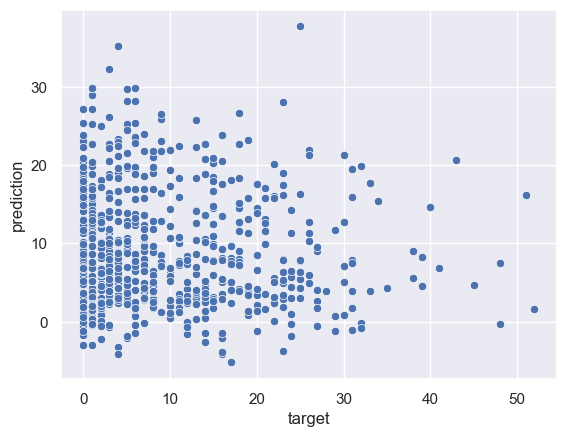

In [127]:
results_df = pd.DataFrame({'target' : []})
results_df["target"] = y_test
results_df["prediction"] = predictions

g = sns.scatterplot(data=results_df, x="target", y="prediction")

We see that the model typically over-estimates the number of scored goals for small targets. 
On the other hand, for targets > 20, the predictions are typically under-estimated.

The following graph shows the distribution of difference `target - prediction` in test data.

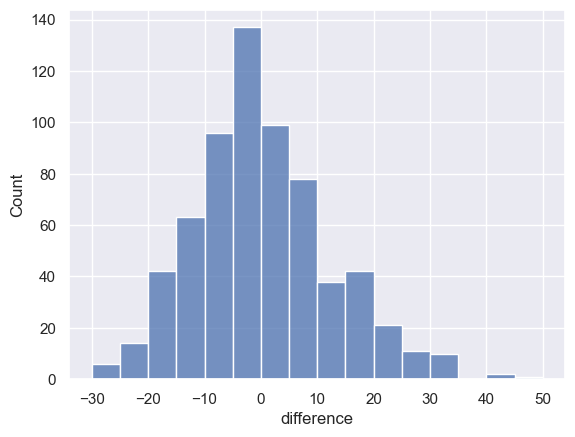

In [126]:
differences_df = pd.DataFrame({'difference' : []})
differences_df['difference'] = y_test - predictions
g = sns.histplot(data=differences_df, x="difference", binwidth=5, binrange=(-30,50))

## Conclusions
